Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Lasha Koroshinadze"
COLLABORATORS = ""

---

# CSE204 - Introduction to Machine Learning - Lab Session 2: parametric models

<img src="https://raw.githubusercontent.com/adimajo/CSE204-2021/master/data/logo.jpg" style="float: left; width: 15%" />

[CSE204-2021](https://moodle.polytechnique.fr/course/view.php?id=12838) Lab session #02

Jérémie DECOCK - Adrien EHRHARDT

## Objectives

- Introduction to parametric models
- Calculate by hand a linear regression
- Implement a linear regressor using gradient descent
- Linear regression with Scikit Learn
- Implement a polynomial regressor with Scikit Learn

## Imports and tool functions

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing

In [3]:
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d


def gen_1d_linear_regression_samples(n_samples: int = 20) -> pd.DataFrame:
    """
    Generate one-dimensional linear regression samples

    :param int n_samples: number of samples to generate
    """
    x = np.random.uniform(low=-10., high=10., size=n_samples)
    y = 2. * x + 3. + np.random.normal(scale=2., size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    return df


def gen_1d_polynomial_regression_samples(n_samples: int = 15) -> pd.DataFrame:
    """
    Generate one-dimensional polynomial regression samples

    :param int n_samples: number of samples to generate
    """
    x = np.random.uniform(low=0., high=10., size=n_samples)
    y = 3. - 2. * x + x ** 2 - x ** 3 + np.random.normal(scale=10., size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    return df


def plot_1d_regression_samples(dataframe: pd.DataFrame, model=None):
    """
    Plot the regression samples in one-D with the predictions if model is provided

    :param pandas.DataFrame dataframe: a dataframe containing the :code:`x` feature and
        :code:`y` dependent feature to regress on.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    df = dataframe.copy()  # make an alias
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x', 'y']"
    assert df.columns.values.tolist() == ['x', 'y'], ERROR_MSG1
    
    if model is not None:
        # Compute the model's prediction
        x_pred = np.linspace(df.x.min(), df.x.max(), 100).reshape(-1, 1)
        y_pred = model.predict(x_pred)
        df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])
        df_pred.plot(x='x', y='y', style='r--', ax=ax)

    # Plot also the training points
    df.plot.scatter(x='x', y='y', ax=ax)
    delta_y = df.y.max() - df.y.min()
    plt.ylim((df.y.min() - 0.15 * delta_y,
              df.y.max() + 0.15 * delta_y))


def plot_ex2(X: np.array, y: np.array, theta_0: float = None, theta_1: float = None):
    """
    Puts X and y in a dataframe and plot the result; expects one-dimensional inputs X and y.
    If theta_0 and theta_1 are provided, calculate and plot y_hat as well.

    :param numpy.array X: one-dimensional regression feature
    :param numpy.array y: one-dimensional target feature
    :param float theta_0: constant linear regression coefficient
    :param float theta_1: linear regression coefficient associated with X
    """
    df = pd.DataFrame(np.array([X, y]).T, columns=['x', 'y'])

    ax = df.plot.scatter(x="x", y="y")

    if theta_0 is not None and theta_1 is not None:
        x = np.array([1, 9])
        y = theta_0 + theta_1 * x

        ax.plot(x, y, "--r")


def plot_ex4(X: np.array, y: np.array, theta_1: float = None, theta_2: float = None):
    """
    Puts X and y in a dataframe and plot the result; expects one-dimensional inputs X and y.
    If theta_1 and theta_2 are provided, calculate and plot y_hat = theta_1 * x + theta_2 * x**2 as well.

    :param numpy.array X: one-dimensional regression feature
    :param numpy.array y: one-dimensional target feature
    :param float theta_1: linear regression coefficient associated with X
    :param float theta_2: linear regression coefficient associated with X**2
    """
    df = pd.DataFrame(np.array([X, y]).T, columns=['x', 'y'])
    ax = df.plot.scatter(x="x", y="y")

    if theta_1 is not None and theta_2 is not None:
        x = np.linspace(0, 6, 50)
        y = theta_1 * x + theta_2 * x**2
        ax.plot(x, y, "--r")


def plot_contour_2d_solution_space(func,
                                   fig=None,
                                   ax=None,
                                   show=True,
                                   theta_min: np.array = -np.ones(2),
                                   theta_max: np.array = np.ones(2),
                                   theta_star: np.array = None,
                                   theta_visited: np.array = None,
                                   title: str = ""):
    """
    Plot points visited during the execution of an optimization algorithm.

    """
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(12, 8))

    if theta_visited is not None:
        theta_min = np.amin(np.hstack([theta_min.reshape([-1, 1]), theta_visited]), axis=1)
        theta_max = np.amax(np.hstack([theta_max.reshape([-1, 1]), theta_visited]), axis=1)

    x1_space = np.linspace(theta_min[0], theta_max[0], 200)
    x2_space = np.linspace(theta_min[1], theta_max[1], 200)
    x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)
    zz = func(np.array([x1_mesh.ravel(), x2_mesh.ravel()])).reshape(x1_mesh.shape)

    ############################

    if theta_star is not None:
        min_value = func(theta_star)
    else:
        min_value = zz.min()
        
    max_value = zz.max()
    levels = np.logspace(0.1, 3., 5)
    im = ax.pcolormesh(x1_mesh,
                       x2_mesh,
                       zz,
                       vmin=min_value,
                       vmax=max_value,
                       shading='gouraud',
                       cmap='gnuplot2')

    plt.colorbar(im, ax=ax)

    cs = plt.contour(x1_mesh,
                     x2_mesh,
                     zz,
                     levels,
                     linewidths=(2, 2, 2, 2, 3),
                     linestyles=('dotted', '-.', 'dashed', 'solid', 'solid'),
                     alpha=0.5,
                     colors='white')
    ax.clabel(cs, inline=False, fontsize=12)

    ############################

    if theta_visited is not None:
        ax.plot(theta_visited[0],
                theta_visited[1],
                '-og',
                alpha=0.5,
                label="$visited$")

    ############################

    if theta_star is not None:
        sc = ax.scatter(theta_star[0],
                        theta_star[1],
                        c='red',
                        label=r"$\theta^*$")
        sc.set_zorder(10)        # put this point above every thing else

    ############################

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(r"$\theta_0$", fontsize=16)
    ax.set_ylabel(r"$\theta_1$", fontsize=16)
    ax.legend(fontsize=16)

    if show:
        plt.show()

    return fig, ax


def plot_2d_solution_space(func,
                           fig=None,
                           ax=None,
                           show=True,
                           theta_min=-np.ones(2),
                           theta_max=np.ones(2),
                           theta_star=None,
                           angle_view=None,
                           title=""):
    """Plot points visited during the execution of an optimization algorithm."""
    if fig is None or ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = axes3d.Axes3D(fig)

    if angle_view is not None:
        ax.view_init(angle_view[0], angle_view[1])

    x1_space = np.linspace(theta_min[0], theta_max[0], 100)
    x2_space = np.linspace(theta_min[1], theta_max[1], 100)

    x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)

    zz = func(np.array([x1_mesh.ravel(), x2_mesh.ravel()])).reshape(x1_mesh.shape)

    ############################

    surf = ax.plot_surface(x1_mesh,
                           x2_mesh,
                           zz,
                           cmap='gnuplot2',
                           norm=colors.LogNorm(),
                           rstride=1,
                           cstride=1,
                           shade=False)

    ax.set_zlabel(r"$E(\theta)$")

    fig.colorbar(surf, shrink=0.5, aspect=5)

    ############################

    if theta_star is not None:
        ax.scatter(theta_star[0],
                   theta_star[1],
                   func(theta_star),
                   c='red',
                   alpha=1,
                   label=r"$\theta^*$")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(r"$\theta_0$", fontsize=16)
    ax.set_ylabel(r"$\theta_1$", fontsize=16)

    if show:
        plt.show()

    return fig, ax

## Introduction

Today you will learn to solve regression problems using **parametric models** (the application of parametric models to classification problems will be the subject of another session): you will use a parametric function $f_{\boldsymbol{\theta}}: \boldsymbol{x} \mapsto y$ to infer the link existing between input vectors $\boldsymbol{x} \in \mathbb{R}^p$ and output values $y \in \mathbb{R}$ in a *learning set* $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$ of $n$ examples.

The *hypothesis space* $\mathcal{H}$ of $f_{\boldsymbol{\theta}}$ is chosen *a priori*, so that the model fits reasonably well the data in $\mathcal{D}$. For instance, $\mathcal{H}$ can be the space of linear functions if the data seems to be distributed along a line in $\mathcal{D}$. The space of polynomial functions of degree $d>1$ may be a good choice otherwise.

The parameter $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ is then searched to obtain the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$. This is an optimization problem.

For instance, assume you have chosen the space of linear functions to make a model that describes the data in $\mathcal{D}$, and $p=1$ (one-dimensional regression).

Your model is then $y = \theta_0 + \theta_1 x$ and the regression problem consists in finding the best parameters (strictly speaking, estimators of these parameters) $\theta_0^\star$ and $\theta_1^\star$ for it.

**Note**: there are some differences in notations with the lecture slides: parameters are noted $w$ (for "weights": machine learning community) in lectures but they are noted $\theta$ (for parameters: statistics community) here.

## Linear regression: an analytic definition of the optimal parameters

We have a *learning set* $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$.

We assume:
- Errors (difference between actual labels $y$ and predicted labels $\hat{y} = f_{\theta}(\boldsymbol{x})$) are gaussian random values centered at 0: $y = f_{\boldsymbol{\theta}}(\boldsymbol{x}) + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
- Data is modeled with a linear function: $f_{\boldsymbol{\theta}}(\boldsymbol{x}) = \theta_0 + \sum_{j=1}^p \theta_j \boldsymbol{x}_j = (1 \; x)^T \boldsymbol{\theta}$.

- Observations $\boldsymbol{x} \in \mathbb{R}^p$ can be defined as $p$ random values $X_1, X_2, \dots, X_p$
- Labels $y$ are then realizations of a random value $Y$ such that:

$$Y \sim \mathcal{N}(\underbrace{f(\boldsymbol{x} | \boldsymbol{\theta})}_{\mu}, \sigma^2)$$

We want to find the estimator $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ that gives the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$ (optimization problem).

Finding the best $\boldsymbol{\theta}^*$ is a maximum likelihood problem : $\boldsymbol{\theta}^* \leftarrow {\arg\!\max}_{\boldsymbol{\theta}} \mathbb{P}(\mathcal{D}|\boldsymbol{\theta})$.
Here, it is equivalent to apply the method of *least squares* or to minimize the Mean Square Error (MSE).
Using matrix notation, we define the linear regression problem as:

$$\boldsymbol{\theta}^* \leftarrow {\arg\!\min}_{\boldsymbol{\theta}} E(\boldsymbol{\theta}) \quad \text{with} \quad E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^2$$

and

$$
\boldsymbol{X} = \begin{pmatrix} 1 & x_1^{(1)} & \dots & x_p^{(1)} \\ \vdots & \vdots & \dots & \vdots \\ 1 & x_1^{(n)} & \dots & x_p^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} y^{(1)} \\ \vdots \\ y^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \vdots \\ \theta_p \end{pmatrix}.
$$

$E(\boldsymbol{\theta})$ is a quadratic form (convex function) thus it has a unique global minimum $\boldsymbol{\theta^*}$ where $\nabla_{\boldsymbol{\theta^*}} E(\boldsymbol{\theta^*}) = \boldsymbol{0}$

### Exercise 1

On a sheet of paper:
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$ of the Mean Square Error $E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^2$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta^*}$

You can first use $p=1$, but with a greater value of $p$, matrix notation (and calculus) will come in handy.

$$
E(\boldsymbol{\theta}) = \boldsymbol{y}^{T}\boldsymbol{y}-2\boldsymbol{\theta}^{T}\boldsymbol{X}^{T}\boldsymbol{y}+\boldsymbol{\theta}^{T}\boldsymbol{X}^{T}\boldsymbol{X}\boldsymbol{\theta}
$$

$$
\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta}) = -2\boldsymbol{X}^T(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\theta})
$$

$$
\theta^* = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y}
$$

## Example

### Exercise 2

#### Question 1

Use the previous equations to compute **by hand** (i.e. on a sheet of paper) the optimal parameters $\theta_0$ and $\theta_1$ of the model $y = \theta_0 + \theta_1 x$ to best fit the following dataset (of four observations):

$$\mathcal{D} = \left\{
\begin{pmatrix} 2 \\ 1 \end{pmatrix},
\begin{pmatrix} 5 \\ 2 \end{pmatrix},
\begin{pmatrix} 7 \\ 3 \end{pmatrix},
\begin{pmatrix} 8 \\ 3 \end{pmatrix}
\right\}$$

This will require [inverting a 2x2 matrix](https://www.chilimath.com/lessons/advanced-algebra/inverse-of-a-2x2-matrix/).

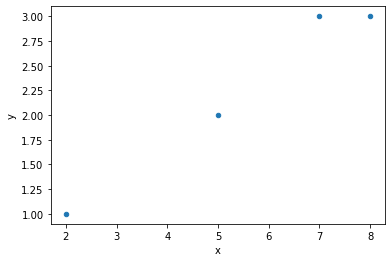

In [4]:
X = [2, 5, 7, 8]
y = [1, 2, 3, 3]

plot_ex2(X, y)  # see in above how this is plotted

We can represent the data with matrices:

$$
\boldsymbol{X} = \begin{pmatrix} 1 & 2 \\ 1 & 5 \\ 1 & 7 \\ 1 & 8 \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} 1 \\ 2 \\ 3 \\ 3 \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \theta_1 \end{pmatrix}
$$

$$
\theta^* = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y}
$$

$$
(\boldsymbol{X}^T \boldsymbol{X})^{-1} = \frac{1}{42} \begin{pmatrix} 71 & -11 \\ -11 & 2 \end{pmatrix}
$$

$$
(\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T =
\frac{1}{42} \begin{pmatrix} 49 & 16 & -6 & -17 \\ -7 & -1 & 3 & 5 \end{pmatrix}
$$

$$
\theta^* = \frac{1}{42} \begin{pmatrix} 12 \\ 15 \end{pmatrix} = \begin{pmatrix} \frac{2}{7} \\ \frac{5}{14} \end{pmatrix}
$$

#### Question 2

Check graphically that the model you obtained fits the data well using the following cell (uncomment and complete the first two lines and uncomment the last one).

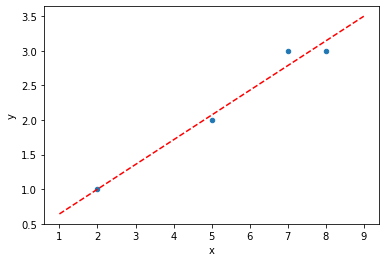

In [5]:
theta_0 = 2 / 7
theta_1 = 5 / 14

plot_ex2(X, y, theta_0, theta_1)  # see above how this is plotted

#### Question 3

Plot the MSE $E(\boldsymbol{\theta})$ with the following cells.
What is plotted? What is the input space and the output space?

What can you say about these plots?

In [6]:
X = np.array([[1, 1, 1, 1], X]).T
y = np.array(y).reshape(-1, 1)

In [7]:
class MSE:
    def __init__(self, X, y):
        self.X = np.copy(X)
        self.y = np.copy(y)
        
    def __call__(self, theta):
        return ((np.tile(self.y, theta.shape[1]) - np.dot(self.X, theta))**2).sum(axis=0)
    
mse = MSE(X, y)

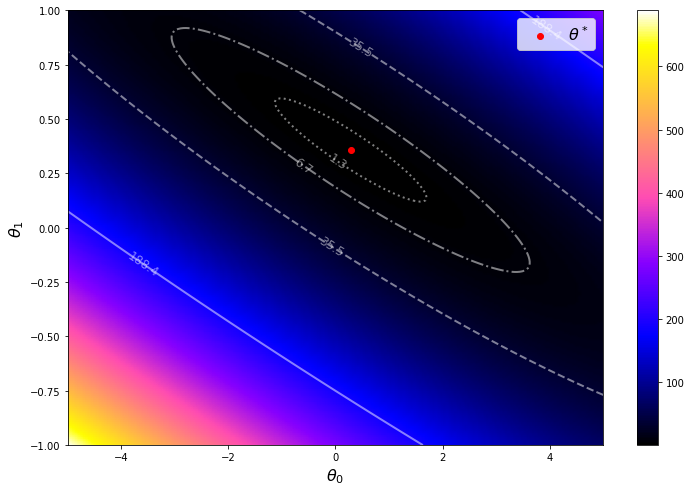

In [8]:
# see above how this is plotted
plot_contour_2d_solution_space(mse,
                               theta_min=np.array([-5, -1]),
                               theta_max=np.array([5, 1]),
                               theta_star=np.array([[theta_0], [theta_1]]));

C:\Users\lasha\AppData\Local\Temp/ipykernel_11344/1884705798.py:196: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


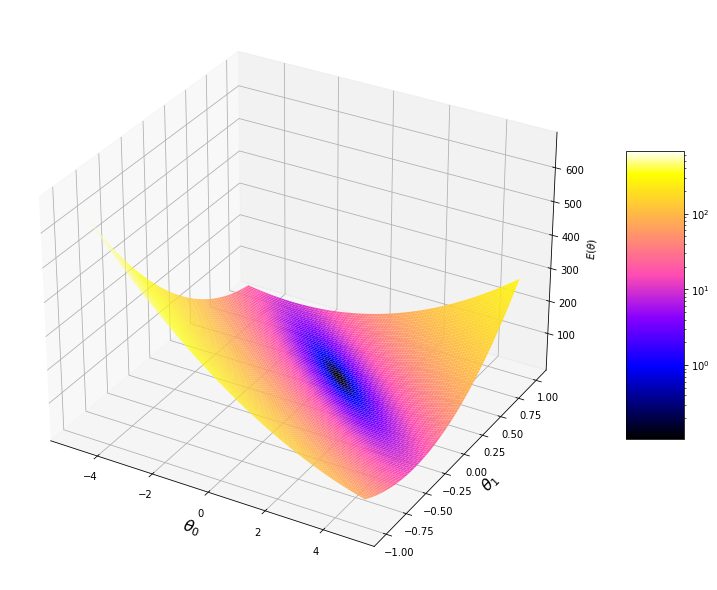

In [9]:
# see above how this is plotted
plot_2d_solution_space(mse,
                       theta_min=np.array([-5, -1]),
                       theta_max=np.array([5, 1]));

On the graphs we see how $E(\boldsymbol{\theta})$ is depended on $\theta_0$ and $\theta_1$. The input space is $\boldsymbol{R}^2$, and the output space is $\boldsymbol{R}$. Darker spots mean that gradient is close to $0$.

## Linear regression: an approximated solution using a *gradient descent* method

When $(X^TX)^{-1}$ cannot be easily computed (e.g. no analytical solution or $\mathcal{D}$ contains a lot of examples or the dimension of the solution space $\mathcal{X}$ is too large), an approximated solution can be computed using a *gradient descent method*.

Also, we'll use *gradient descent* for other models than linear regression, so this will serve as an introduction.

$\nabla_{\theta}E(\hat{\theta})$ gives the direction of the largest slope at the point $\hat{\theta}$.
Thus, if we explore iteratively the parameter space by following the opposite direction of this gradient as described in the following definition, we should converge to the parameter $\boldsymbol{\theta}^\star$ that minimizes the MSE, i.e. the parameter $\theta^\star$ such that $\nabla_{\theta^\star}E({\theta^\star}) = 0$.

Starting from a random point $\boldsymbol{\theta}$, the gradient descent method proposes a new point 
$\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})$ at each iteration until a stopping criterion has been reached: e.g. $||\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})||_2^2 > \epsilon_{\delta}$ with $\epsilon_{\delta}$ a chosen minimal length for the gradient to continue iterations.

The *learning rate* $\eta \in \mathbb{R}_+^*$ is a parameter to tweak for the considered problem.
- If $\eta$ is too large, the optimization may not converge toward 0.
- If $\eta$ is too small, the optimization may require a lot of iterations to converge.

### Exercise 3

#### Question 1

In our one-dimensional example of four points, calculate the expression of the gradient.

We can represent the data with matrices:

$$
\boldsymbol{X} = \begin{pmatrix} 1 & 2 \\ 1 & 5 \\ 1 & 7 \\ 1 & 8 \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} 1 \\ 2 \\ 3 \\ 3 \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \theta_1 \end{pmatrix}
$$

$$
E(\boldsymbol{\theta}) = \boldsymbol{y}^{T}\boldsymbol{y}-2\boldsymbol{\theta}^{T}\boldsymbol{X}^{T}\boldsymbol{y}+\boldsymbol{\theta}^{T}\boldsymbol{X}^{T}\boldsymbol{X}\boldsymbol{\theta}
$$

$$
\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta}) = -2\boldsymbol{X}^T(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\theta})
$$

Implement a gradient descent method to solve exercise 2 with an approximated solution.
Use the analytic formulation of $\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})$ that has been computed in exercise 1.

You can use a very basic stopping criterion: the number of iterations (e.g. 10000).
You can start with $\eta = 0.001$.

In [10]:
def gradient_descent(X, y, eta=0.001, max_iteration=10000, 
                     theta=np.random.normal(loc=0, scale=10, size=[2, 1])):

    # Perform useful matrix multiplication
    XTy = -2 * np.matmul(np.transpose(X), y)
    XTX = -2 * np.matmul(np.transpose(X), X)

    grad_list = []      # Keep the gradient of all iterations
    theta_list = []     # Keep the solution of all iterations

    for i in range(max_iteration):
        # Perform the gradient descent here
        grad = XTy - np.matmul(XTX, theta)
        theta = theta - eta * grad

        grad_list.append([grad[0][0], grad[1][0]])      # Keep the gradient
        theta_list.append([theta[0][0], theta[1][0]])   # Keep the solution

    return grad_list, theta_list

In [11]:
grad_list, theta_list = gradient_descent(X, y)

dataframe_grad = pd.DataFrame(grad_list, columns=["grad1", "grad2"])
dataframe_theta = pd.DataFrame(theta_list, columns=["theta1", "theta2"])

dataframe_theta.tail()  # Display the last lines and observe convergence to what you found analytically

,theta1,theta2
9995,0.285767,0.357135
9996,0.285767,0.357135
9997,0.285767,0.357135
9998,0.285767,0.357135
9999,0.285767,0.357135


#### Question 2

Print or plot the value of $\theta$ and $E(\theta)$ obtained at each iteration.
Check that $E(\theta)$ converges to 0 and that $\theta$ converges to the solution obtained in exercise 2.

You can make use of `df_theta` as provided in the previous cell.

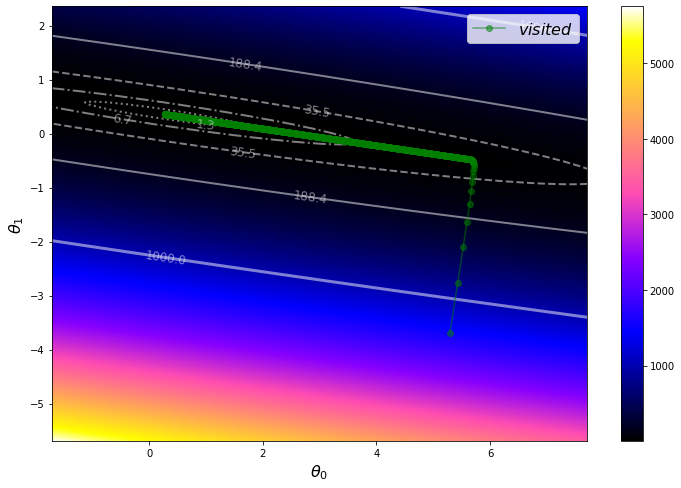

In [12]:
theta_min = dataframe_theta.min().values
theta_max = dataframe_theta.max().values
theta_visited = np.transpose(dataframe_theta.values)

plot_contour_2d_solution_space(mse,
                               theta_min=theta_min - 2.,
                               theta_max=theta_max + 2.,
                               theta_visited=theta_visited);

#### Question 3

Print or plot the norm of the gradient. You can make use of `dataframe_grad` provided earlier. How do you interpret it?

In [13]:
def plot_gradient(df_gradient: pd.DataFrame):

    # Put the norm of the gradient at each iteration in a column named "norm"
    df_gradient['norm'] = np.sqrt(np.square(df_gradient).sum(axis=1))

    ax = df_gradient.norm.plot(loglog=True, figsize=(16, 8))

    ax.set_title(r"Evolution of $||\nabla_{\theta} E(\theta)||_2$", fontsize=16)
    ax.set_xlabel("Iteration number", fontsize=16)
    ax.set_ylabel(r"Norm of $\nabla_{\theta} E(\theta)$", fontsize=16);

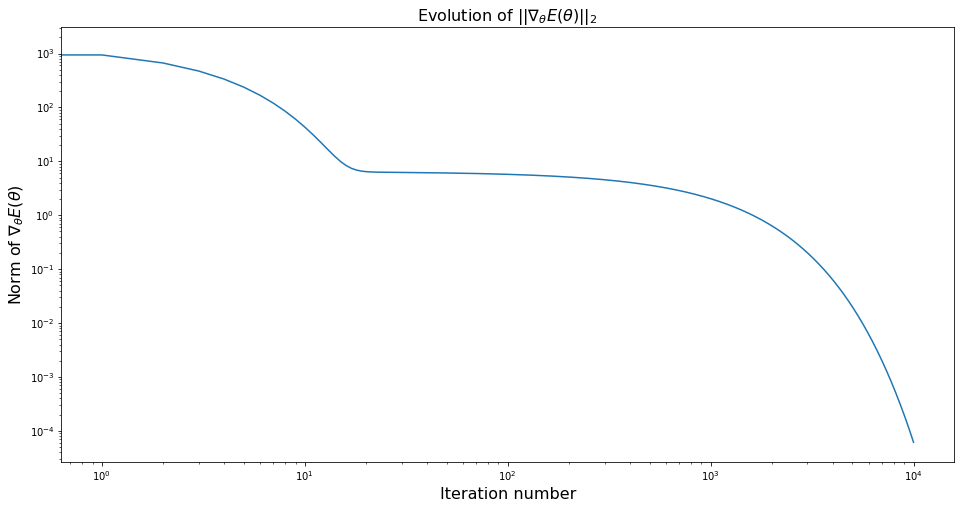

In [14]:
plot_gradient(dataframe_grad)

#### Question 4

Restart the optimization using a different *learning rate* $\eta$. What do you observe?

If the learning rate is very small, we might not be able to reach the spot where gradient is close to zero.

In [15]:
# Try with different values of eta (and optionally theta) IN SEPARATE CODE CELLS
def display_theta_visited_norm(eta=0.000001, theta=np.array([[7],[2]]), max_iteration=10000):
    grad_list, theta_list = gradient_descent(X, y, eta, max_iteration, theta)

    # Use the same procedure as previously:
    df_grad = pd.DataFrame(grad_list, columns=["grad1", "grad2"])
    df_theta = pd.DataFrame(theta_list, columns=["theta1", "theta2"])
    theta_min = df_theta.min().values
    theta_max = df_theta.max().values
    theta_visited = np.transpose(df_theta.values)

    # see above how this is plotted
    plot_contour_2d_solution_space(mse,
                                   theta_min=theta_min - 2.,
                                   theta_max=theta_max + 2.,
                                   theta_visited=theta_visited);

    # Computing the norm
    plot_gradient(df_grad)

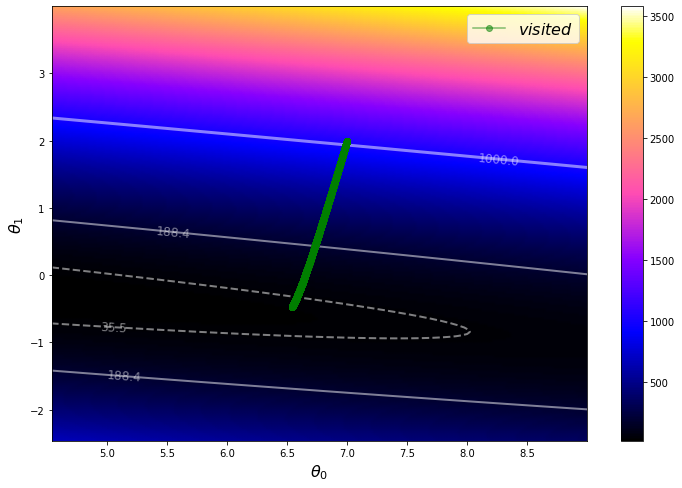

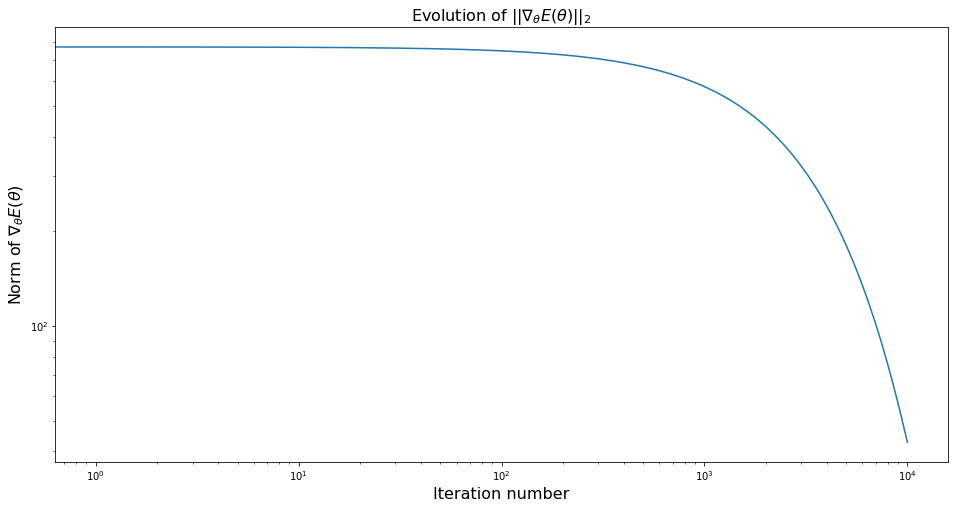

In [16]:
display_theta_visited_norm()

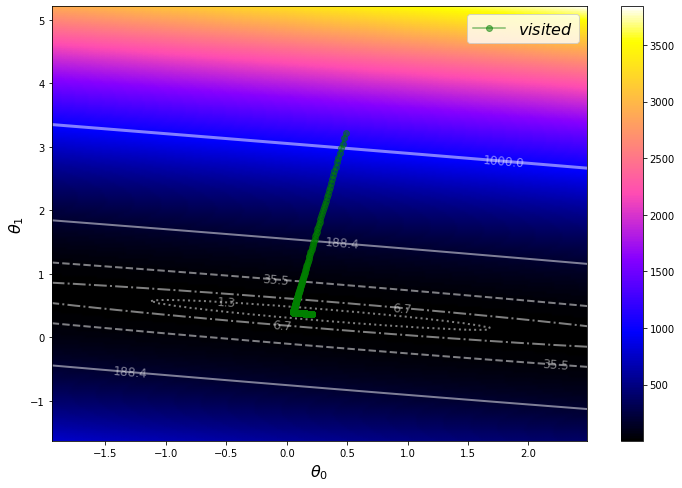

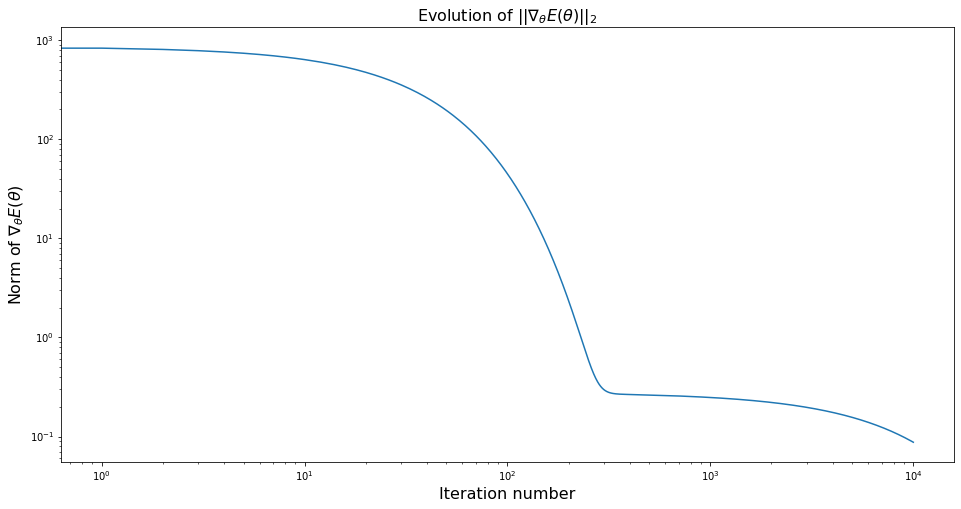

In [17]:
display_theta_visited_norm(eta=0.0001, theta=np.array([[0.5],[3.3]]), max_iteration=10000)

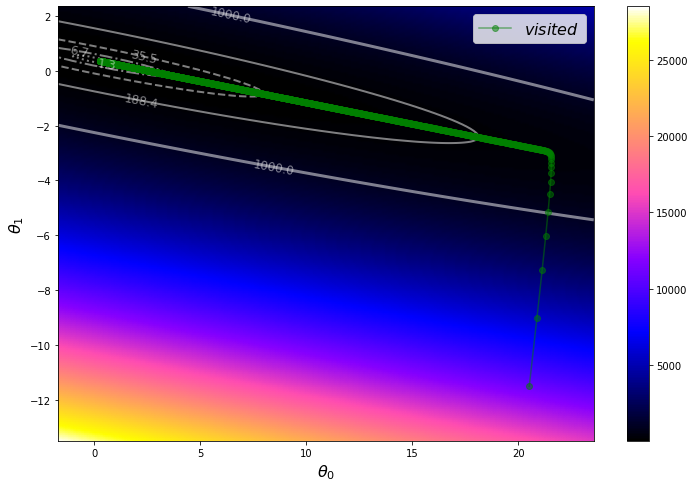

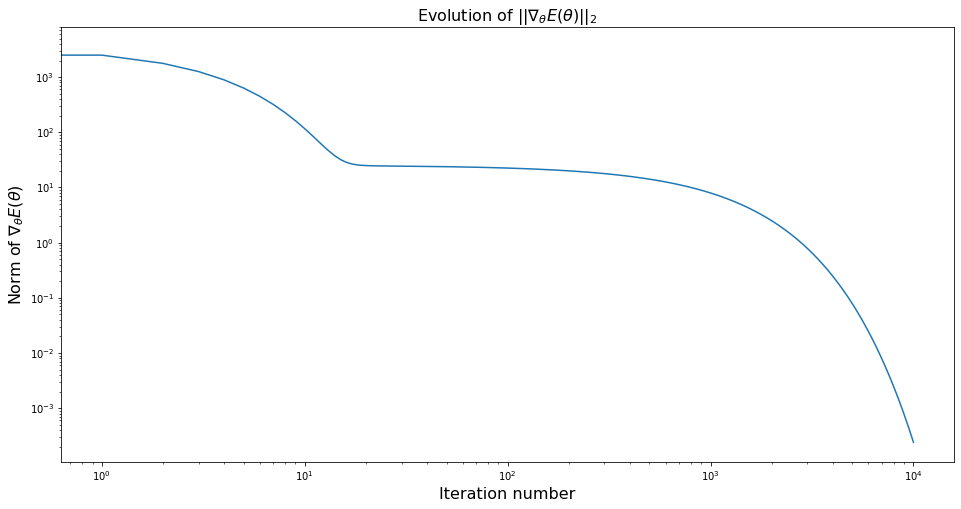

In [18]:
display_theta_visited_norm(eta=0.001, theta=np.array([[20],[-15]]), max_iteration=10000)

There is a sweet spot where we are able to get the gradient close to zero.

If the learning rate is too large, then we bounce on the curve and might go to infinity, where we get an overflow error.

## Linear regression with Scikit Learn

Let's play with the Scikit Learn implementation of linear regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html

Use the `gen_1d_linear_regression_samples()` function (defined above) to generate a dataset and `plot_1d_regression_samples()` to plot it.

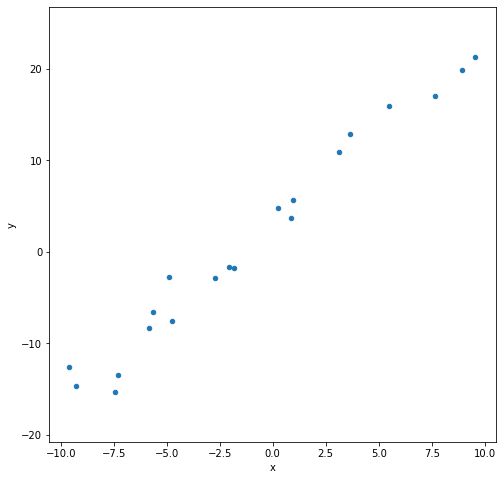

In [19]:
df = gen_1d_linear_regression_samples()

plot_1d_regression_samples(df)

Once the dataset is ready, let's make the regressor and train it with the following code:

In [20]:
linear_model = sklearn.linear_model.LinearRegression()

linear_model.fit(df[['x']], df[['y']])

LinearRegression()

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

c:\users\lasha\.python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


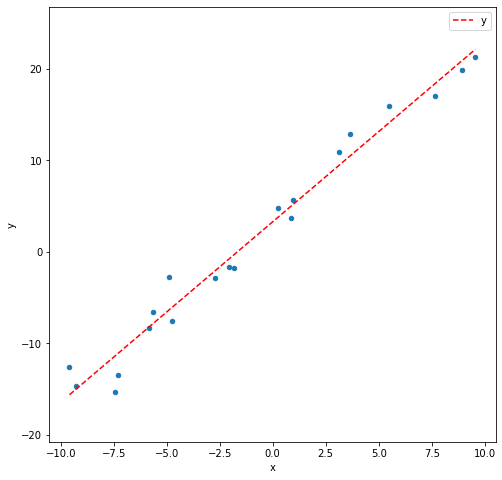

In [21]:
plot_1d_regression_samples(df, model=linear_model)

### Exercise 4

#### Question 1

What are the optimal parameters $\theta_1$ (intercept) and $\theta_2$ obtained? Put them in `intercept` and `slope`.
(Note: there are attributes to the `LinearRegression` class which provide them)

In [22]:
intercept = float(linear_model.intercept_)
slope = float(linear_model.coef_)

#### Question 2

Write the mathematical definition of the generated data (see above) and your model.

Implement both as a function of X and plot it.

$f(X)=3+2X$

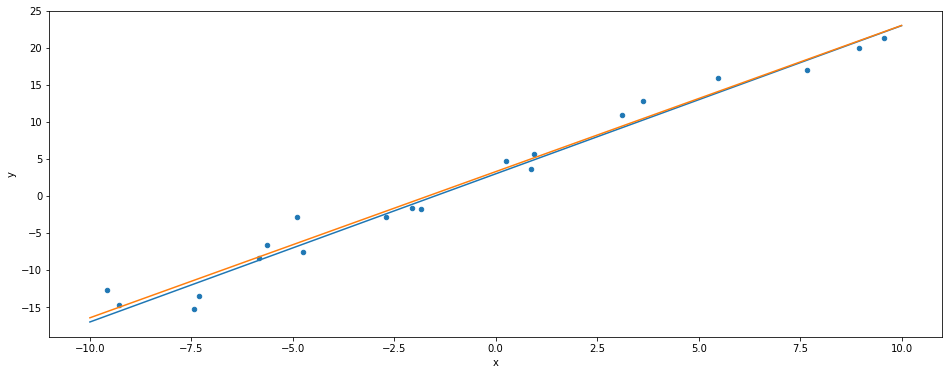

In [23]:
def f(X):
    return 3 + 2 * X

def f_hat(X):
    return intercept + slope * X

ax = df.plot.scatter(x='x', y='y', figsize=(16, 6))

X = np.array([-10, 10])
ax.plot(X, f(X))
ax.plot(X, f_hat(X));

#### Question 3

Use the `model.predict()` function to guess the class of the following points in a *vectorized* way (i.e. applying the `predict` method on an array, and returning and an array); put the result in `linear_predictions`:

$$x_{p1} = -2, \quad x_{p2} = 2, \quad x_{p3} = 6$$

In [24]:
predictions = linear_model.predict(np.array([[-2], [2], [6]]))

c:\users\lasha\.python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Polynomial regression

It is a common practice to use linear models trained on nonlinear transformations of the input data in machine learning. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

For instance, a linear model can be extended by making polynomial features from the coefficients. Linear model in exercises 1 and 2 looks like this (one-dimensional data):

$$f_{\theta}(x) = \theta_0 + \theta_1 x$$

If we want to fit a quadratic curve to the data instead of a line, we can combine the features in second-order polynomials, so that the model looks like this:

$$f_{\theta}(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

This is still a linear model: to illustrate this, we can create a new variable

$$z = [x, x^2]$$

With this re-labeling of the data, our problem can be written

$$f_{\theta}(x) = \theta_0 + \theta_1 z_1 + \theta_2 z_2$$

The resulting polynomial regression is in the same class of linear models we'd considered above (i.e. the model is linear in $\theta$) and can be solved by the same techniques. Thus the linear model has the flexibility to fit a much broader range of data.

### Exercise 5

#### Question 1

Use the previous equations to compute **by hand** (i.e. on a sheet of paper) the optimal parameters $\theta_1$ and $\theta_2$ of the model $y = \theta_1 x + \theta_1 x^2$ to best fit the following dataset (of four examples):

$$\mathcal{D} = \left\{
\begin{pmatrix} 1 \\ 1.8 \end{pmatrix},
\begin{pmatrix} 2 \\ 2.7 \end{pmatrix},
\begin{pmatrix} 3 \\ 3.4 \end{pmatrix},
\begin{pmatrix} 4 \\ 3.8 \end{pmatrix},
\begin{pmatrix} 5 \\ 3.9 \end{pmatrix}
\right\}.$$

$$
\boldsymbol{X} = \begin{pmatrix} 1 & 1 \\ 2 & 4 \\ 3 & 9 \\ 4 & 16 \\ 5 & 25 \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} 1.8 \\ 2.7 \\ 3.4 \\ 3.8 \\ 3.9 \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_1 \\ \theta_2 \end{pmatrix}
$$

$$
\theta^* = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y}
$$

$$
(\boldsymbol{X}^T \boldsymbol{X})^{-1} = \frac{1}{42} \begin{pmatrix} 71 & -11 \\ -11 & 2 \end{pmatrix}
$$

$$
(\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T =
\frac{1}{42} \begin{pmatrix} 49 & 16 & -6 & -17 \\ -7 & -1 & 3 & 5 \end{pmatrix}
$$

$$
\theta^* = \frac{1}{42} \begin{pmatrix} 12 \\ 15 \end{pmatrix} = \begin{pmatrix} \frac{2}{7} \\ \frac{5}{14} \end{pmatrix}
$$

You can (optionnally) check your results using `numpy`.

In [25]:
X = np.array([1, 2, 3, 4, 5])
X = np.transpose(np.array([X, X ** 2]))
y = y = [1.8, 2.7, 3.4, 3.8, 3.9]
XT = np.transpose(X)
XTX = np.matmul(XT, X)
XTX1 = np.linalg.inv(XTX)
XTX1XT = np.matmul(XTX1, XT)
theta = np.matmul(XTX1XT, y)
theta

array([ 1.76037267, -0.19875776])

Let's plot these points:

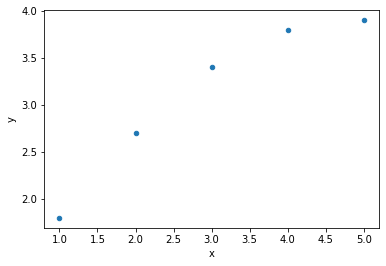

In [26]:
X = [1, 2, 3, 4, 5]
y = [1.8, 2.7, 3.4, 3.8, 3.9]

plot_ex4(X, y)

#### Question 2

Check graphically that the model you obtained fits the data well using the following cell (complete the first two lines).

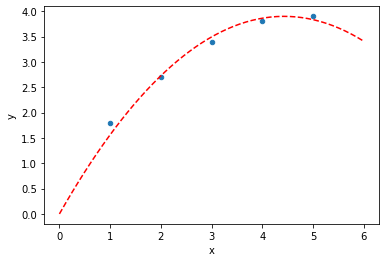

In [27]:
X = [1, 2, 3, 4, 5]
y = [1.8, 2.7, 3.4, 3.8, 3.9]

theta_1 = theta[0]
theta_2 = theta[1]

plot_ex4(X, y, theta_1, theta_2)

## Polynomial regression with Scikit Learn

Let's play with the Scikit Learn implementation of polynomial regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions

First we generate the dataset, plot it, instantiate a regressor and train it with the following code:

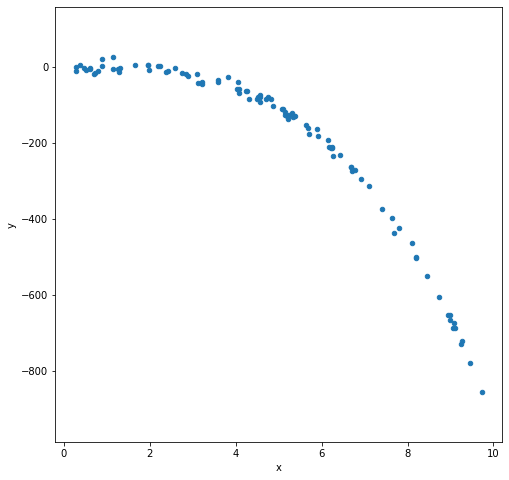

In [28]:
df = gen_1d_polynomial_regression_samples(n_samples=100)

plot_1d_regression_samples(df)

polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=3)  # In Q. 4, try with degree = 1, 4 and 15

def learn_poly_model(poly_features: sklearn.preprocessing.PolynomialFeatures):
    linear_regression = sklearn.linear_model.LinearRegression(fit_intercept=False)

    model = sklearn.pipeline.Pipeline([("polynomial_features", polynomial_features),
                                       ("linear_regression", linear_regression)])

    model.fit(df[['x']], df[['y']])
    return linear_regression, model

linear_regression, model = learn_poly_model(polynomial_features)

In `sklearn.preprocessing.PolynomialFeatures()`, `degree` is the degree of the polynomal function.

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

c:\users\lasha\.python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


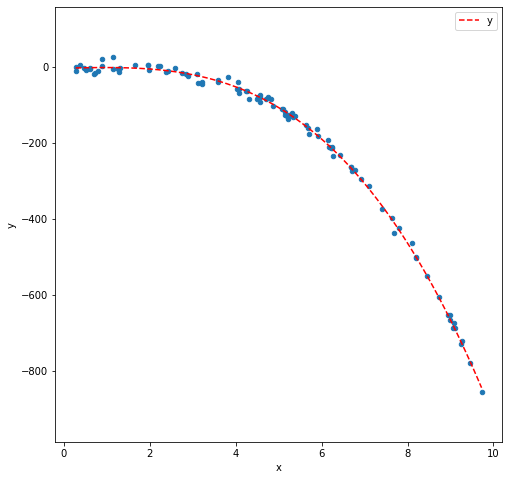

In [29]:
plot_1d_regression_samples(df, model=model)

### Exercise 6

#### Question 1

What are the optimal parameters $\theta_0, \theta_1, \theta_2, \theta_3$ obtained? Check the attributes of `linear_regression`.

In [30]:
theta_0 = linear_regression.coef_[0, 0]
theta_1 = linear_regression.coef_[0, 1]
theta_2 = linear_regression.coef_[0, 2]
theta_3 = linear_regression.coef_[0, 3]

#### Question 2

Write the mathematical definition of the generated data (see above) and your model. Plot the result.

$f(X)=3-2X+X^2-X^3$

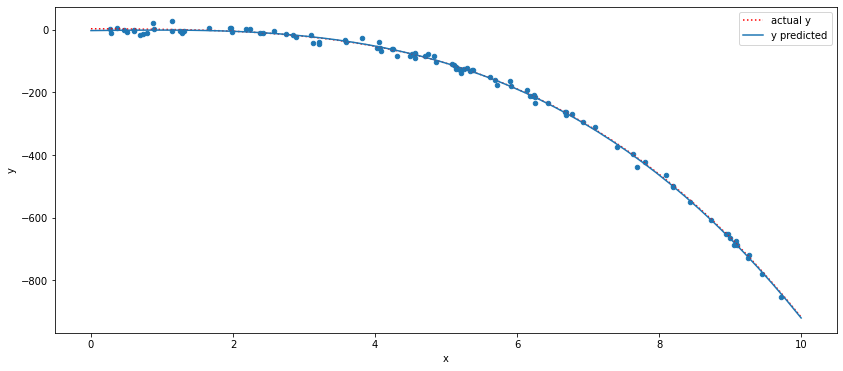

In [31]:
x = np.linspace(0., 10., 50)

y_hat = theta_0 + theta_1 * x + theta_2 * x ** 2 + theta_3 * x ** 3
y = 3. - 2. * x + x ** 2 - x ** 3

ax = df.plot.scatter(x='x', y='y', figsize=(14, 6))

df_model = pd.DataFrame(np.array([x, y, y_hat]).T, columns=['x', 'y', 'y_pred'])

df_model.plot(x='x', y='y', style=':r', label='actual y', ax=ax)
df_model.plot(x='x', y='y_pred', label='y predicted', ax=ax);

#### Question 3

Use the `model.predict()` function to infer the `y` value of the following points:

$$x_{p1} = 1, \quad x_{p2} = 2, \quad x_{p3} = 6$$

In [32]:
predictions = model.predict([[1], [2], [6]])

c:\users\lasha\.python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


#### Question 4

In `sklearn.preprocessing.PolynomialFeatures()`, change the value of `degree` and describe what happen on the plot (use e.g. 1 and 15 - possibly with fewer observations).
What is the name of the observed phenomenons?

In the case below we have under fitting, since there are not enough degrees of freedom.

c:\users\lasha\.python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


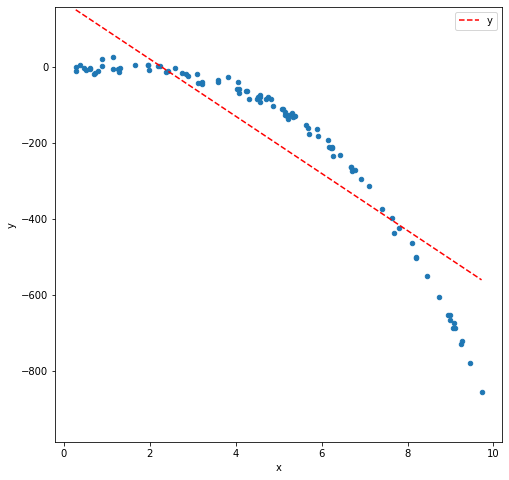

In [33]:
polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=1)

linear_regression, model = learn_poly_model(polynomial_features)

plot_1d_regression_samples(df, model=model)

In the case below we have over fitting, since the model is complex and can fit the data very well, but be quite off on other places.

c:\users\lasha\.python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


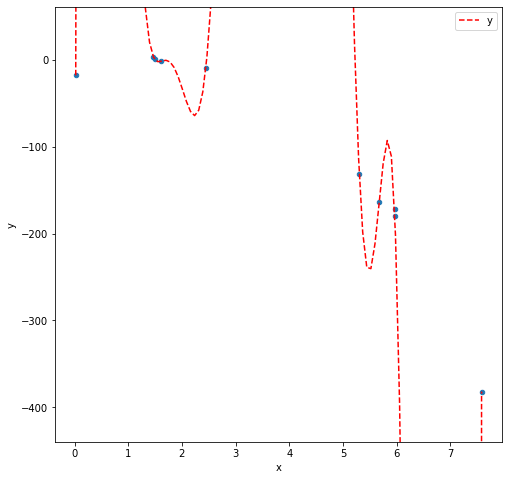

In [34]:
df = gen_1d_polynomial_regression_samples(n_samples=10)

polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=9)

linear_regression, model = learn_poly_model(polynomial_features)

plot_1d_regression_samples(df, model=model)

## CO2 Emission Forecast (bonus)

In this exercise, you will forecast 5 years of future CO2 emission from power generation using natural gas.

This exercise use a dataset taken from https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima.

This public dataset contain monthly carbon dioxide emissions from electricity generation. The dataset includes CO2 emissions starting January 1973 to July 2016.

In [35]:
URL = "https://raw.githubusercontent.com/adimajo/CSE204-2021/master/data/natural_gas_co2_emissions_for_electric_power_sector.csv"

df = pd.read_csv(URL,
                 parse_dates=[0]) #, index_col=0) #, squeeze=True)
df.head()

,date,co2_emissions
0,1973-01-31,12.175
1,1973-02-28,11.708
2,1973-03-31,13.994
3,1973-04-30,14.627
4,1973-05-31,17.344


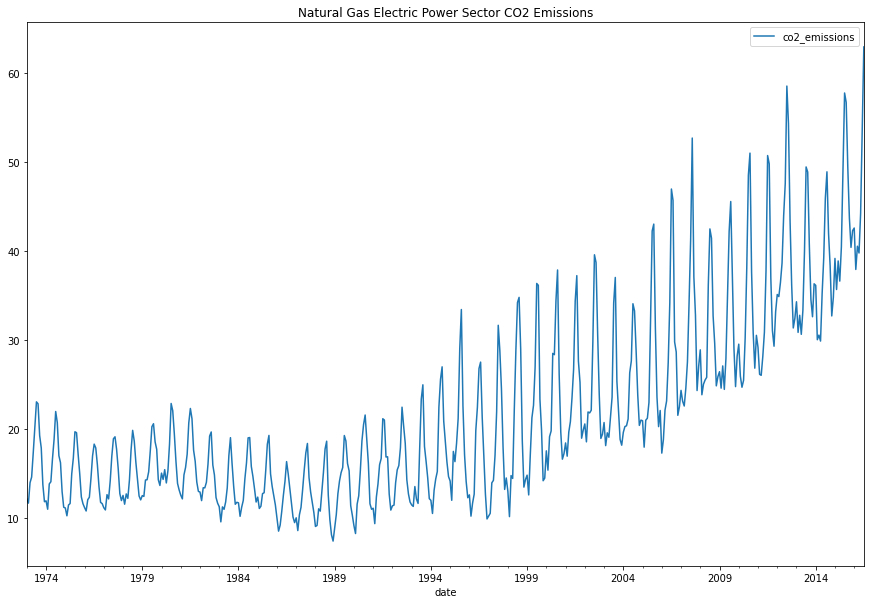

In [36]:
df.plot(x='date', y='co2_emissions', figsize=(15,10), title='Natural Gas Electric Power Sector CO2 Emissions');

### Exercise 7 (bonus)

Implement a model to make predictions on this dataset.
Use polynomial basis functions plus two sinusoids to handle the seasonality of this time series: $\sin(\frac{2 \pi}{12} x)$ and $\cos\left(\frac{2 \pi}{12} x \right)$. This signal contains a periodic component of 12 time steps (where one time step equals to one month).

We use both $\sin$ and $\cos$ to avoid unaligned phases with the time series. Alternatively, we could use only $\sin\left(\frac{2 \pi}{12} (x + \phi)\right)$ or $\cos\left(\frac{2 \pi}{12} (x + \phi)\right)$ as long as $\phi$ is properly set: $\phi = \pi / 2$ in the first case and $\phi = 0$ in the second one.

What are the limitations of this model?

#

In [37]:
#

#

In [38]:
#

#

In [39]:
#

#

In [40]:
#

#

In [41]:
#

#

In [42]:
#